In [1]:
import os
import sys
import time
import numpy as np
import cv2
import random

from tqdm import tqdm
from glob import glob

from utils.common import *
from pathlib import Path
from shapely.geometry import Polygon, MultiPoint, Point
from matplotlib import pyplot as plt

In [2]:
data_path = Path("./data/layout")
detect_path = Path("./runs/detect/layout")
h, w = 1456, 1928

K = np.array([
    [975.813843, 0, 960.973816],
    [0, 975.475220, 729.893921],
    [0, 0, 1]
])
num_cams = 4

cam_poses = {}
for i in range(num_cams):
    with open(f'./camera_poses/{i:05d}.txt', 'r') as f:
        lines = f.readlines()
        pose = []
        for line in lines:
            data = list(map(float, line.split(" ")))
            pose.append(data)
        pose = np.array(pose)
        cam_poses[f'cam{i}'] = pose.reshape(4, 4)
plane_coeffs = get_plane_coeffs(K, cam_poses)

img = [cv2.imread(str(data_path / f"cam{id}" / "00000.jpg")) for id in range(num_cams)]

In [3]:
def kmeans(rgbs, numWords=10):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    _, _, vocab = cv2.kmeans(rgbs, numWords, None, criteria, attempts, flags)
    print('kmeans time: {:6}s'.format(time.time() - start_time))

    vocab_col = [[max(0, min(255, c)) for c in word] for word in vocab]
    return vocab, vocab_col

def im_clustering(im, step=5):
    start_time = time.time()
    rgbs = []
    for x in range(0, w, step):
        for y in range(0, h, step):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)

    vocab, vocab_col = kmeans(rgbs)

    bf = cv2.BFMatcher()
    rgbs = []
    for x in range(w):
        for y in range(h):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)
    matches = bf.knnMatch(rgbs, vocab, k=1)

    out = np.array([[vocab_col[matches[x * h + y][0].trainIdx] for x in range(w)] for y in range(h)], dtype=np.uint8)
    print('Clustering time: {:6}s'.format(time.time() - start_time))
    return out

kmeans time: 2.4555327892303467s


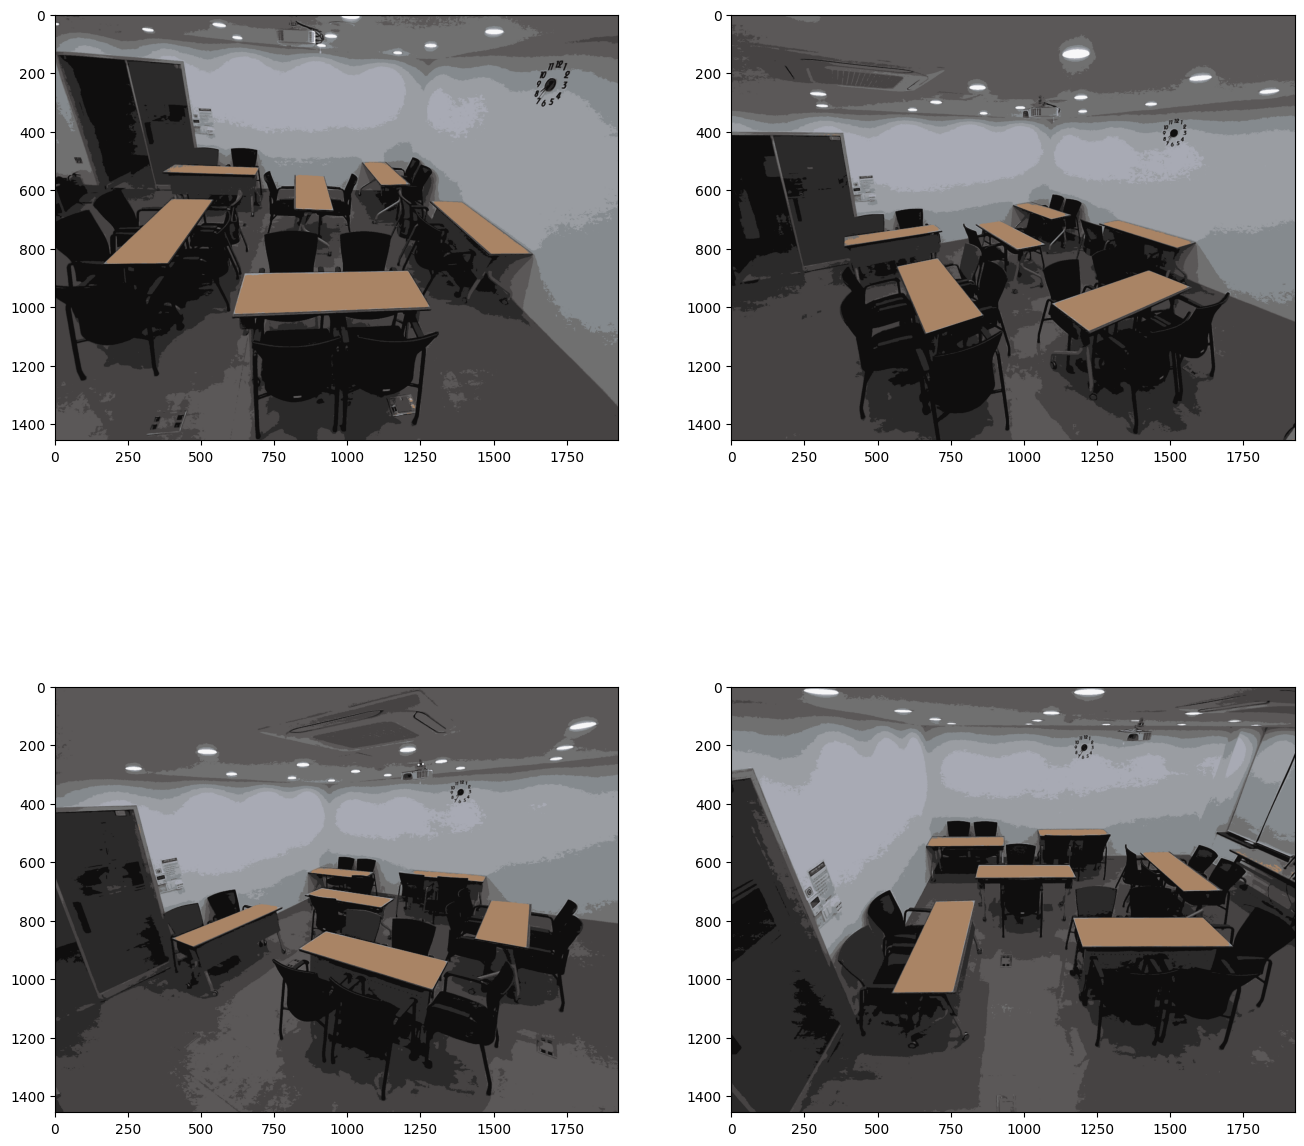

In [4]:
rgbs = []
step = 5
for id in range(num_cams):
    im = img[id]
    for x in range(0, w, step):
        for y in range(0, h, step):
            rgbs.append(im[y][x].tolist())
rgbs = np.array(rgbs, dtype=np.float32)

vocab, vocab_col = kmeans(rgbs)

bf = cv2.BFMatcher()
plt.figure(figsize=(16,16))
for id in range(num_cams):
    rgbs = []
    im = img[id]
    for x in range(w):
        for y in range(h):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)
    matches = bf.knnMatch(rgbs, vocab, k=1)

    out = np.array([[vocab_col[matches[x * h + y][0].trainIdx] for x in range(w)] for y in range(h)], dtype=np.uint8)
    plt.subplot(2, 2, id + 1)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [5]:
# test utils.common methods
bboxes = [
    [1034.999564,  504.000224],
    [1034.999564,  696.000032],
    [1211.999604,  696.000032],
    [1211.999604,  504.000224]]
mx_px = np.array([4.24737756, 6.90199759])
mi_px = np.array([-2.55125312, 0.51182116])
width = 800
height = int(width * (mx_px[0] - mi_px[0]) / (mx_px[1] - mi_px[1]))

t1 = pixel2plane(bboxes, K, cam_poses[f'cam0'][:3,:], plane_coeffs)
t2 = plane2layout(t1, plane_coeffs)
t3 = p2px(t2, mi_px, mx_px, width, height)
t4 = px2p(t3, mi_px, mx_px, width, height)
t5 = layout2plane(t2, plane_coeffs)
t6 = reprojection(t5, K, cam_poses[f'cam0'])
print(t6)

[[1034.999564  504.000224]
 [1034.999564  696.000032]
 [1211.999604  696.000032]
 [1211.999604  504.000224]]


In [6]:
table_output = {}
px = []
for id in range(num_cams):
    tables = []
    with open(str(detect_path / f"cam{id}" / "labels" / "00000.txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            data = list(map(float, line.split(" ")))
            if data[0] == 60: # table
                bboxes = np.array([
                    [(data[1] - data[3] / 2) * w, (data[2] - data[4] / 2) * h],
                    [(data[1] - data[3] / 2) * w, (data[2] + data[4] / 2) * h],
                    [(data[1] + data[3] / 2) * w, (data[2] + data[4] / 2) * h],
                    [(data[1] + data[3] / 2) * w, (data[2] - data[4] / 2) * h],
                ])
                # cam plane -> 3d position
                bboxes = pixel2plane(bboxes, K, cam_poses[f'cam{id}'][:3,:], plane_coeffs)

                # 3d position -> table plane 2d
                bboxes = plane2layout(bboxes, plane_coeffs)
                tables.append(bboxes)
        mx, mi = get_bbox(np.concatenate(tables, axis=0))
        px += [mx] + [mi]
        table_output[f'cam{id}'] = tables

mx_px, mi_px = get_bbox(np.stack(px, axis=0))
print(mx_px, mi_px)

[ 4.24737743 -0.51182119] [-2.55125316 -6.90199772]


In [7]:
def matchByOverlap(after_bboxes, before_bboxes_transformed):
    overlaps = []
    for i, after_bbox in enumerate(after_bboxes):
        after_bbox_polygon = Polygon(after_bbox)
        for j, before_bbox_transformed in enumerate(before_bboxes_transformed):
            before_bbox_transformed_polygon = Polygon(before_bbox_transformed)
            if(after_bbox_polygon.intersects(before_bbox_transformed_polygon)):
                overlap = after_bbox_polygon.intersection(before_bbox_transformed_polygon).area
                total = after_bbox_polygon.area + before_bbox_transformed_polygon.area - overlap
                percentage = overlap/total
                # percentage = overlap/after_bbox_polygon.area
                overlaps.append([i, j, percentage])
    overlaps.sort(key = lambda x : x[-1], reverse=True)
    
    after_indices = set(range(len(after_bboxes)))
    before_indices = set(range(len(before_bboxes_transformed)))

    selected = []
    for i, j, _ in overlaps:
        if i in after_indices and j in before_indices:
            # i : index in bboxes (cam(i+1))
            # j : index in transformed_bboxes (cam(i) -> cam(i+1))
            selected.append([i, j])
            after_indices.remove(i)
            before_indices.remove(j)

    return selected

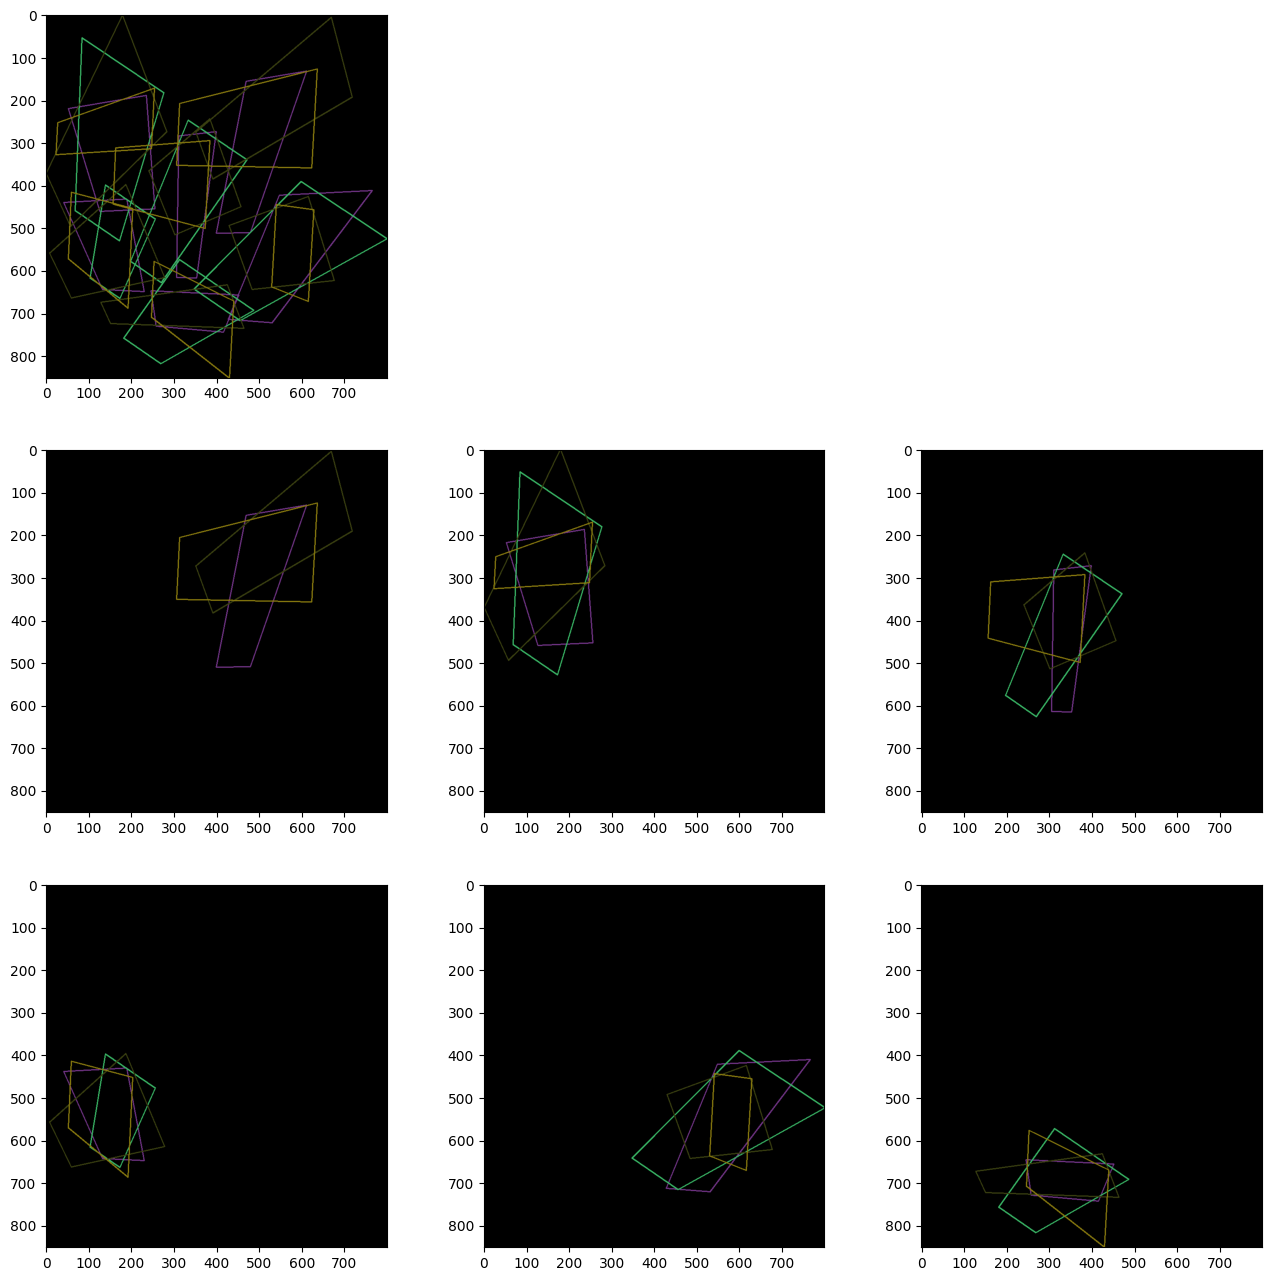

In [10]:
width = 800
height = int(width * (mx_px[0] - mi_px[0]) / (mx_px[1] - mi_px[1]))

plt.figure(figsize=(16, 16))
out = np.zeros((height, width, 3), dtype=np.uint8)
tables = {}
col = []
for id in range(num_cams):
    col.append(tuple(np.random.rand(3) * 255))
    tables[f'cam{id}'] = p2px(table_output[f'cam{id}'], mi_px, mx_px, width, height)
    out = cv2.polylines(out, tables[f'cam{id}'], True, col[id], 2)

plt.subplot(3, 3, 1)
plt.imshow(out)

edge = {}
V = []
checked = {}
for id in range(num_cams):
    for t in range(len(tables[f'cam{id}'])):
        edge[(id, t)] = []
        checked[(id, t)] = False
        V.append((id, t))

for id1 in range(num_cams):
    for id2 in range(id1 + 1, num_cams):
        matched = matchByOverlap(tables[f'cam{id1}'], tables[f'cam{id2}'])
        for t1, t2 in matched:
            edge[(id1, t1)].append((id2, t2))
            edge[(id2, t2)].append((id1, t1))

groups = []
for v in V:
    if checked[v]:
        continue
    checked[v] = True
    queue = [v]
    g = []
    while len(queue) > 0:
        now = queue.pop(0)
        g.append(now)
        for u in edge[now]:
            if not checked[u]:
                checked[u] = True
                queue.append(u)
    groups.append(g)

for i, group in enumerate(groups):
    im = np.zeros((height, width, 3), dtype=np.uint8)
    for cid, tid in group:
        im = cv2.polylines(im, [tables[f'cam{cid}'][tid]], True, col[cid], 2)
    plt.subplot(3, 3, i + 3 + 1)
    plt.imshow(im)
    

100%|██████████| 4/4 [00:50<00:00, 12.57s/it]


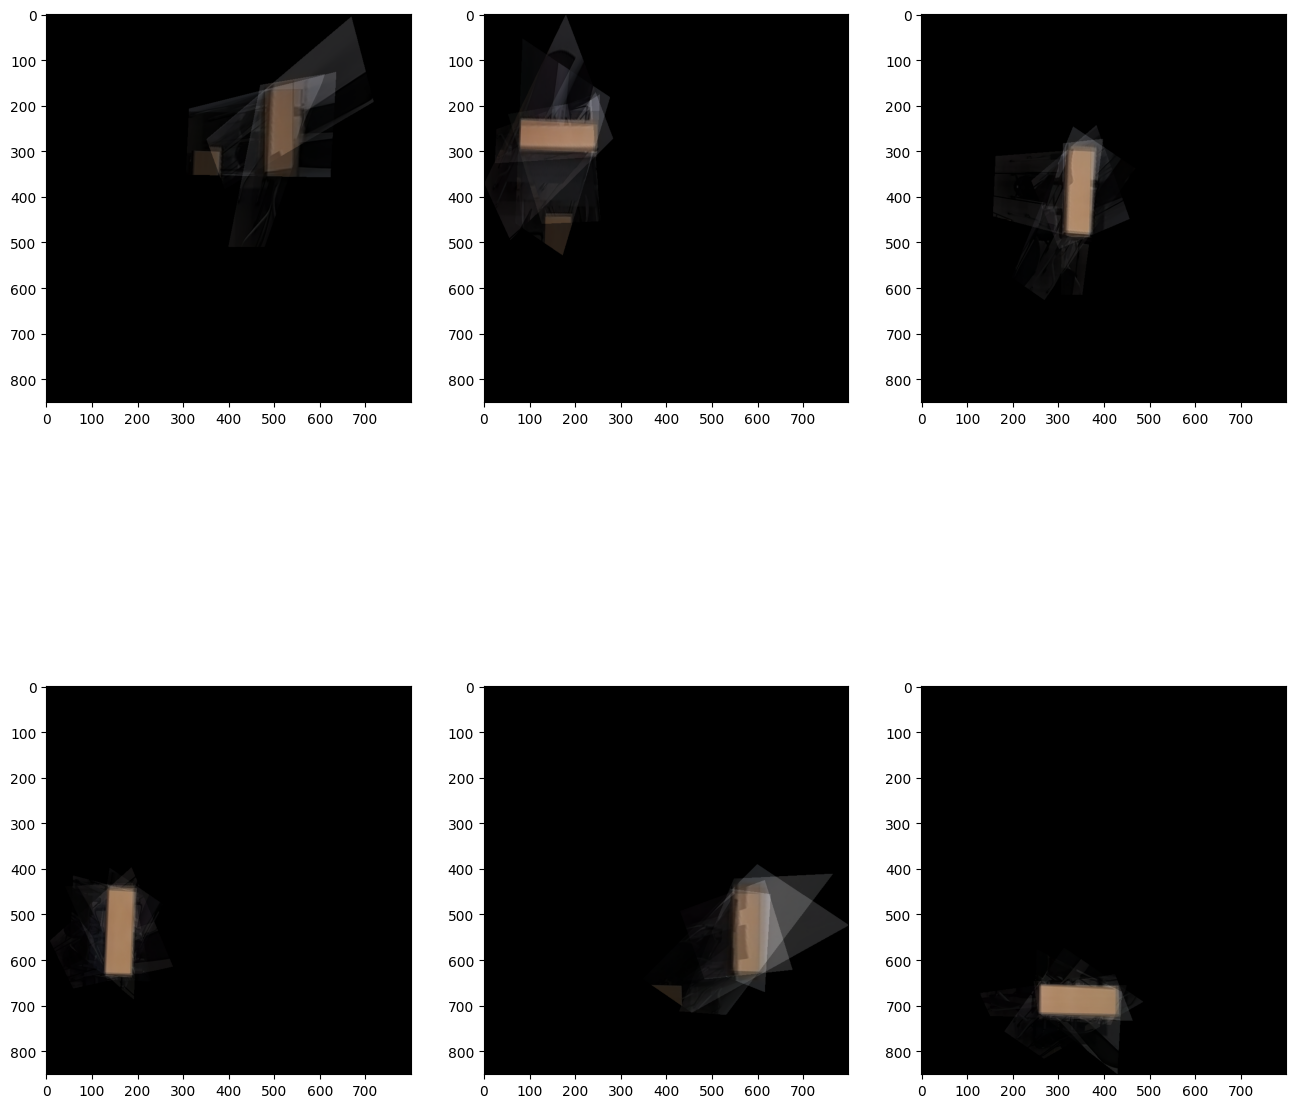

In [41]:
def interpolate(im, r, c):
    a, b = r - int(r), c - int(c)
    r = int(r)
    c = int(c)
    return ((1 - a) * (1 - b) * im[r, c]
        + a * (1 - b) * im[r+1, c]
        + a * b * im[r+1, c+1]
        + (1 - a) * b * im[r, c+1])

plt.figure(figsize=(16, 16))
for i, group in enumerate(groups):
    out = np.zeros((height, width, 3))
    
    for id, tid in tqdm(group):
        polygon = MultiPoint(tables[f'cam{id}'][tid])
        convhull = polygon.convex_hull
        for x in range(int(polygon.bounds[0]), int(polygon.bounds[2]) + 1):
            for y in range(int(polygon.bounds[1]), int(polygon.bounds[3]) + 1):
                if not polygon.convex_hull.contains(Point(x,y)):
                    continue
                t1 = px2p(np.array([x, y]), mi_px, mx_px, width, height).reshape(1, 2)
                t2 = layout2plane(t1, plane_coeffs)
                r_, c_ = reprojection(t2, K, cam_poses[f'cam{id}'])[0][::-1]
                out[y][x] += interpolate(img[id], r_, c_) / num_cams
    plt.subplot(2, 3, i + 1)
    plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB))

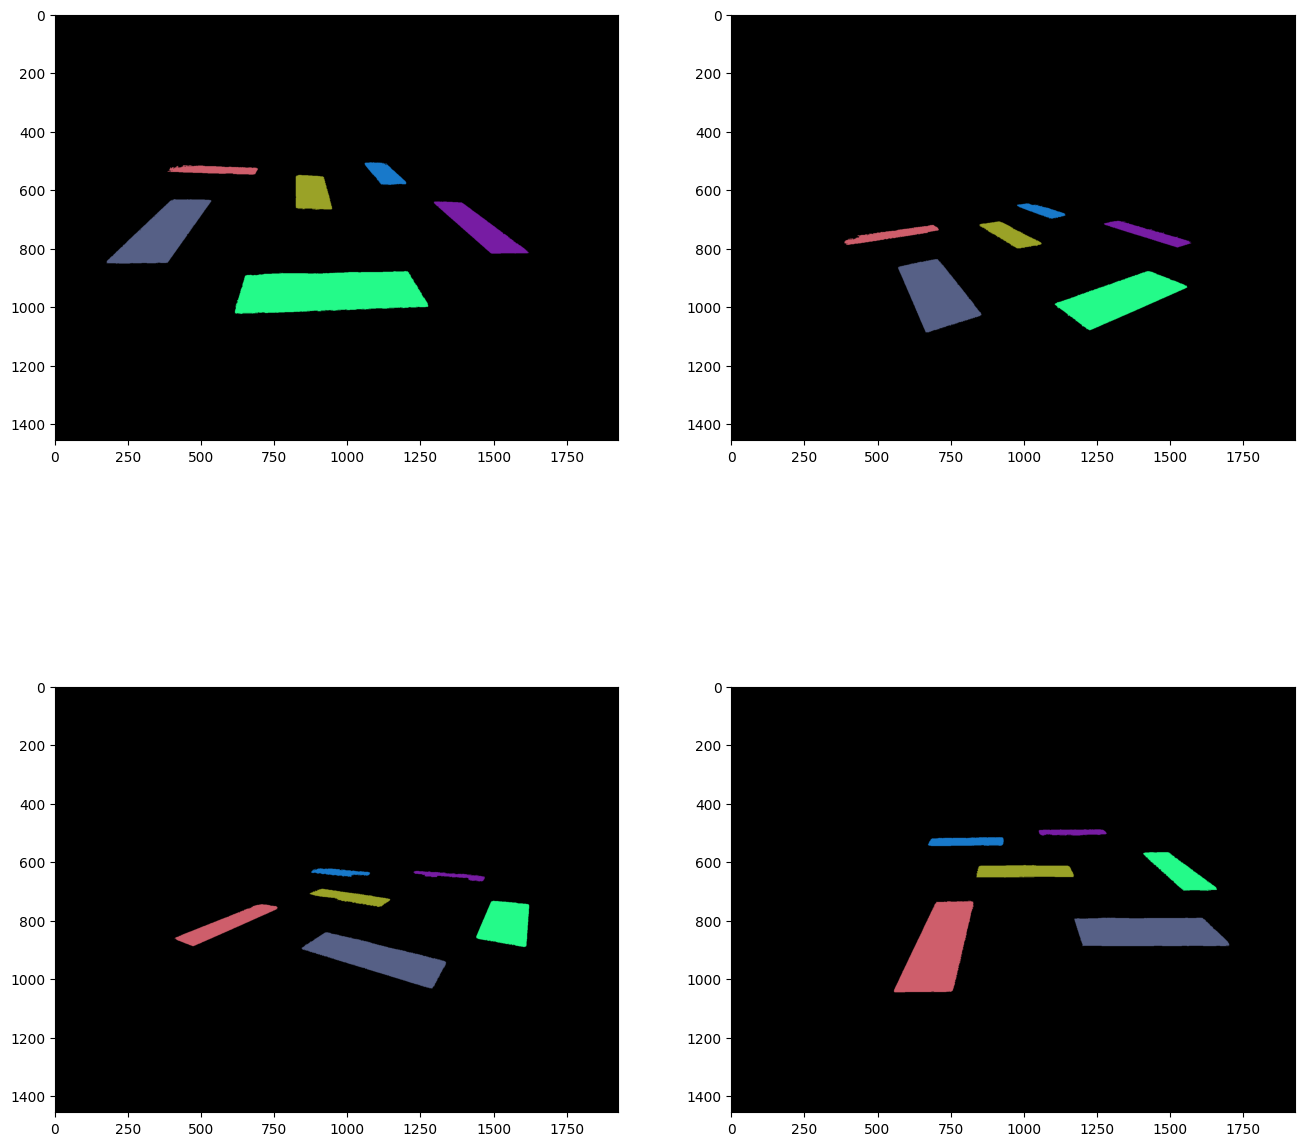

In [15]:
num_samples = 20
bf = cv2.BFMatcher()
result = {"width": width, "height": height, "mx_px": mx_px.tolist(), "mi_px": mi_px.tolist()}
layouts = []

plt.figure(figsize=(16, 16))
out = [np.zeros([h, w, 3]) for _ in range(num_cams)]
for group in groups:
    inter = None
    for id, tid in group:
        if inter is None:
            inter = Polygon(tables[f'cam{id}'][tid])
        else:
            inter = inter.intersection(Polygon(tables[f'cam{id}'][tid]))
    
    samples = []
    while len(samples) < num_samples:
        x = random.randint(int(inter.bounds[0]), int(inter.bounds[2]))
        y = random.randint(int(inter.bounds[1]), int(inter.bounds[3]))
        if inter.contains(Point(x,y)):
            samples.append(np.array([x, y]))
    
    rgbs = []
    rev = []
    for x, y in samples:
        t1 = px2p(np.array([x, y]), mi_px, mx_px, width, height).reshape(1, 2)
        t2 = layout2plane(t1, plane_coeffs)
        for id in range(num_cams):
            r_, c_ = reprojection(t2, K, cam_poses[f'cam{id}'])[0].astype(int)[::-1]
            rgbs.append(img[id][r_][c_])
            rev.append((id, r_, c_))
    rgbs = np.array(rgbs, dtype=np.float32)
    matches = bf.knnMatch(rgbs, vocab, k=1)
    
    import collections
    myCounter = collections.Counter([m[0].trainIdx for m in matches])
    table_class = max(myCounter, key=myCounter.get)

    layout = {f"cam{i}": [] for i in range(num_cams)}
    color = tuple(np.random.rand(3) * 255)
    for i, m in enumerate(matches):
        if m[0].trainIdx != table_class:
            continue
        id, r, c = rev[i]
        if np.count_nonzero(out[id][r][c]) > 0:
            continue

        dx = [0, 1, 0, -1]
        dy = [1, 0, -1, 0]
        queue = [(r, c)]
        out[id][r][c] = color
        while len(queue) > 0:
            x, y = queue.pop()
            layout[f"cam{id}"].append((int(x), int(y)))
            for x_, y_ in zip(dx, dy):
                u, v = x + x_, y + y_
                if h > u > 0 and w > v > 0 and np.count_nonzero(out[id][u][v]) == 0 and bf.knnMatch(np.array([img[id][u][v].astype(np.float32)]), vocab, k=1)[0][0].trainIdx == table_class:
                    queue.append((u, v))
                    out[id][u][v] = color
    
    for id in range(num_cams):
        layout[f"cam{id}"] = sorted(layout[f"cam{id}"])
    
    layouts.append(layout)



# save json file
import json
result["tables"] = layouts
with open("runs/table.json", "w") as outfile:
    json.dump(result, outfile)

# show result
for id in range(num_cams):
    out[id] = out[id].astype(np.uint8)
    plt.subplot(2, 2, id + 1)
    plt.imshow(out[id])